## 1.- Importamos librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from statsmodels.tsa.arima.model import ARIMA

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

## 2.- Procesamos los datos

En primer lugar juntamos todos los DataFrames en un único DataFrame con una list comprehension. Posteriormente eliminamos los NaN y filtramos las mediciones de NO2 (MAGNITUD=8). En el DataSet tenemos datos de varias estaciones de medidas distintas, pero en este primer EDA tomaremos todos los datos sin filtrar por las distintas estaciones.

A continuación creamos la serie temporal teniendo en cuenta LA MEDIA DE LOS VALORES A LO LARGO DE LA SEMANA. Fue la aproximación elegida puesto que considero que es el estadístico que mejor va a describir nuestro sistema.

Por último, como tendremos 365 valores en total, tocará hacer algún tipo de agrupamiento para poder observar las tendencias más claramente. En este caso he elegido agrupar por semanas en lugar de por meses ya que 52 valores nos va a dar una descripción más precisa (menor pérdida de información) que 12 valores.

No obstante, se puede modificar el código cambiando únicamente un valor para así obtener la agrupación por meses o días.

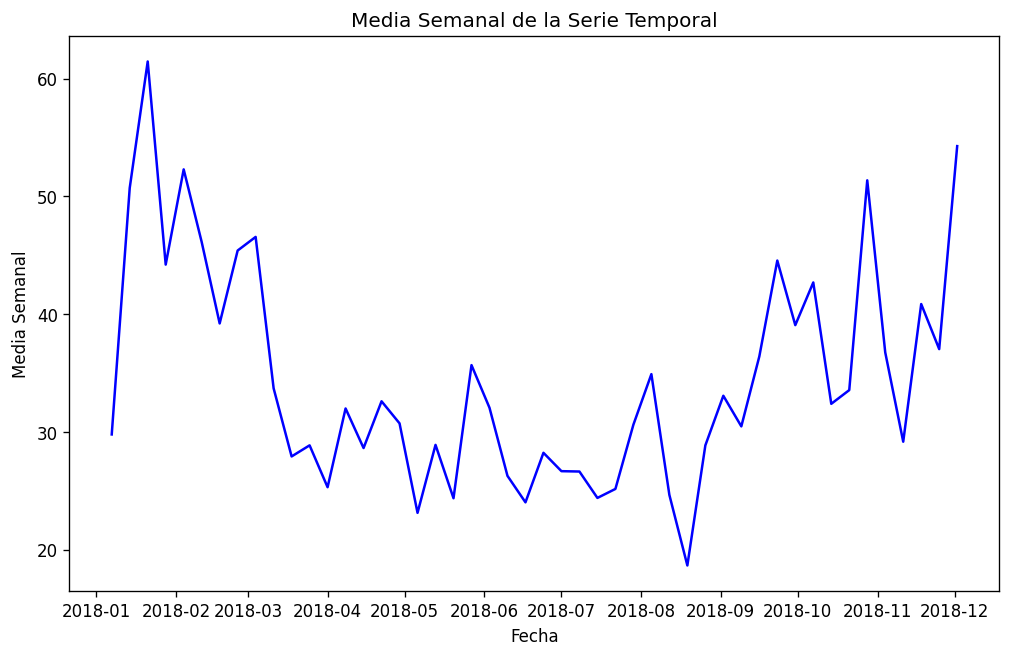

In [3]:
#JUNTAMOS TODOS LOS CSV EN UN UNICO DATAFRAME
path = 'raw\conc_NO2' 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f, sep=";") for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df = concatenated_df.iloc[:,:-1]

#ELIMINAMOS TODOS LOS NAN
df = concatenated_df.dropna(how='any').reset_index()

#PUESTO QUE LAS MEDICIONES DE NO2 CORRESPONDEN A MAGNITUD=8, PROCEDEMOS A FILTRAR DICHOS VALORES 
df = df.loc[df['MAGNITUD'] == 8].reset_index()

#PROCEDEMOS A CREAR LA COL. DATETIME
df_fecha = df.loc[:, ['ANO', 'MES', 'DIA']]
df_fecha.columns = ['year', 'month', 'day']
df_fecha['date'] = pd.to_datetime(df_fecha[['year', 'month', 'day']])
df_fecha = df_fecha['date']

#CREAMOS LA COLUMNA MEDIA_EMISIONES CON LOS VALORES POR HORA
df_media = df.loc[:, ['H01', 'H02', 'H03', 'H04','H05','H06','H07','H08','H09','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23']].mean(axis=1)

#CREAMOS EL DF FINAL Y LO GUARDAMOS COMO CSV
df_final = pd.DataFrame({'Fecha': df_fecha, 'Conc': df_media})
df_final = df_final.sort_values(by='Fecha', ascending=True)
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
df_final.set_index('Fecha', inplace=True)
df_final.to_csv('procesed/serie.csv')
df_final = df_final.resample('W').mean()


#PLOTEAMOS
plt.figure(figsize=(10, 6))
plt.plot(df_final.index, df_final.Conc, color='blue', linestyle='-')
plt.title('Media Semanal de la Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Media Semanal')
plt.grid(False)



Se observa una disminución de la concentración de NO2 en los meses estivales del año, y máximos de noviembre a marzo. Esta tendencia puede deberse a que, durante los meses de verano, la gente tiende a coger menos el coche en las grandes ciudades. Para poder reutilizar el código lo máximo posible, vamos a crear una función que nos permita crear una gráfica de la contaminación en Madrid según los factores:   
 
-Agente contaminante  
-Forma agrupación  
-Filtro por región  (este factor es nuevo respecto a la primera aproximación)


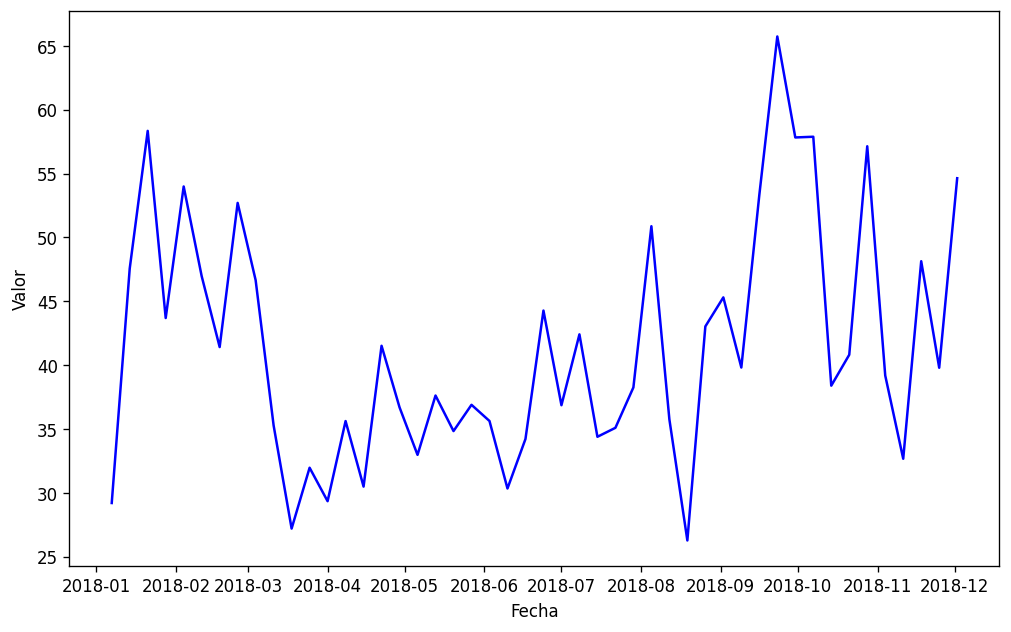

In [4]:
def grafica_contaminación(agente, agrupacion, estacion):
    """Esta funcion nos plotea la contaminación en Madrid en función de tres args, que son, en orden:
    -Agente contaminante: ver tabla con las correspondencias.
    -Forma de agrupación: Acepta D para agrupación por días, W para agrupación por semanas y M para agrupación por meses.
    -Región: Ver tabla para ver el código numérico de cada estación de medida """
    
    path = 'raw\conc_NO2' 
    all_files = glob.glob(os.path.join(path, "*.csv"))     
    df_from_each_file = (pd.read_csv(f, sep=";") for f in all_files)
    concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
    concatenated_df = concatenated_df.iloc[:,:-1]
    df = concatenated_df.dropna(how='any').reset_index()
    df = df.loc[df['MAGNITUD'] == agente].reset_index()
    df = df.loc[df['ESTACION'] == estacion]

    #PROCEDEMOS A CREAR LA COL. DATETIME
    df_fecha = df.loc[:, ['ANO', 'MES', 'DIA']]
    df_fecha.columns = ['year', 'month', 'day']
    df_fecha['date'] = pd.to_datetime(df_fecha[['year', 'month', 'day']])
    df_fecha = df_fecha['date']

    #CREAMOS LA COLUMNA MEDIA_EMISIONES CON LOS VALORES POR HORA
    df_media = df.loc[:, ['H01', 'H02', 'H03', 'H04','H05','H06','H07','H08','H09','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23']].mean(axis=1)

    #CREAMOS EL DF FINAL
    df_final = pd.DataFrame({'Fecha': df_fecha, 'Conc': df_media})
    df_final = df_final.sort_values(by='Fecha', ascending=True)
    df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
    df_final.set_index('Fecha', inplace=True)
    df_final = df_final.resample(agrupacion).mean()
    #PLOTEAMOS
    plt.figure(figsize=(10, 6))
    plt.plot(df_final.index, df_final.Conc, color='blue', linestyle='-')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.grid(False)

grafica_contaminación(8, "W", 4)    #Este ejemplo plotea para NO2 con agrupamiento semanal y para la estación 4, correspondiente con Avda. Ramón y Cajal (Centro)

Ahora procederemos a representar el DataSet de Temperatura vs. Fecha de Madrid, para ver si existe cierta correlación entre ambas variables. Para este dataset vamos a agrupar por temperatura media semanal.

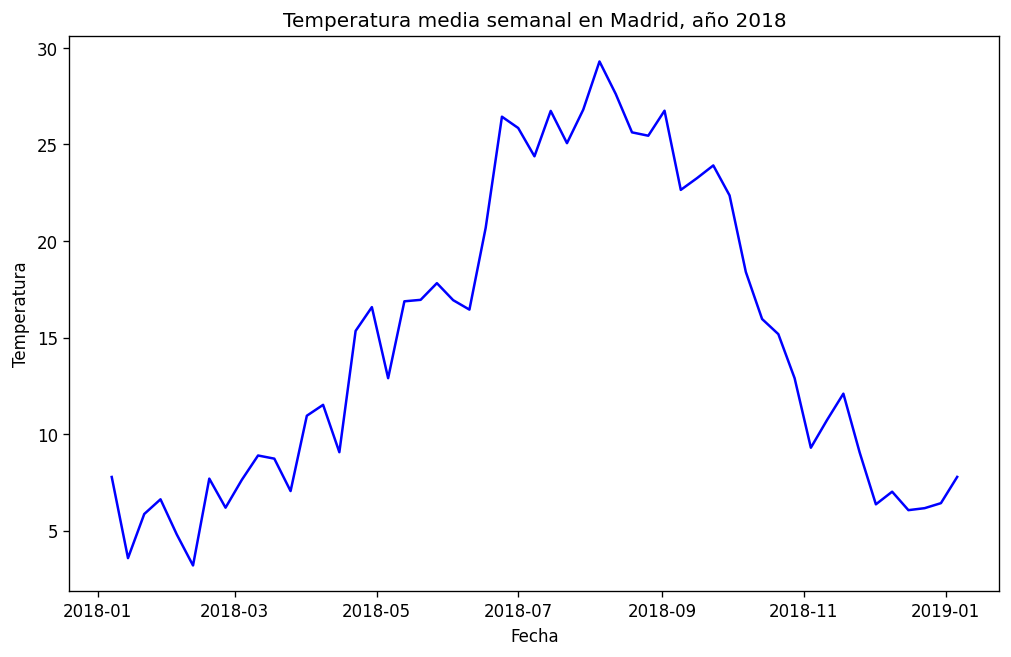

In [80]:
#CREAMOS EL DF Y LO MODIFICAMOS
df_temperatura = pd.read_csv("datasets/madrid_hourly_temperatures_2018.csv")
df_temperatura['date']= pd.to_datetime(df_temperatura['date'])
df_temperatura.set_index('date', inplace=True)
df_temperatura = df_temperatura.resample('W').mean()
df_temperatura

#PLOTEAMOS
plt.figure(figsize=(10, 6))
plt.plot(df_temperatura.index, df_temperatura.temp, color='blue', linestyle='-')
plt.title('Temperatura media semanal en Madrid, año 2018')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.grid(False)


## 3.-Conclusiones y puntos de mejora

La principal conclusión que se extrae es que existe una correlación inversa entre ambos la temperatura y la concentración de NO2 puesto que si comparamos ambas gráficas, vemos que en los meses más calurosos del año la concentración de NO2 troposférico disminuye. La hipótesis nula planteada es que esto se debe a que en los meses de verano el número de desplazamietos en coche es inferior.

Algunos puntos de mejora de este estudio son:  
-En la función grafica_contaminación() crear un diccionario para poder introducir los valores de los agentes contaminantes y de las regiones como strings, y así no tener que buscar sus correspondencias en las tablas.  
-Creación de mapas interactivos con Folium para estudiar la contaminación por regiones.  
-Para la predicción de la contaminación a tres días vista lo mejor sería emplear un modelo ARIMA.

## 4.-EJEMPLO ARIMA

Un posible ejemplo de un modelo ARIMA a tres días vista sería:


In [14]:
data = pd.read_csv('procesed/serie.csv', index_col='Fecha')

# División de datos en entrenamiento y prueba
train = data.iloc[:-3]  # Datos de entrenamiento, excluyendo los últimos tres días
test = data.iloc[-3:]   # Últimos tres días para prueba

# Ajustar el modelo ARIMA
order = (5, 1, 0)  # Parámetros p, d, q del modelo ARIMA
model = ARIMA(train, order=order)
fit_model = model.fit()

# Realizar predicciones para los próximos tres días
predictions = fit_model.forecast(steps=3)

print(predictions)


c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


8003    59.665964
8004    61.277754
8005    62.967867
Name: predicted_mean, dtype: float64


c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
